In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
from sklearn.preprocessing import LabelEncoder

# Load CSVs
train_df = pd.read_csv("data/fairface_label_train.csv")
val_df = pd.read_csv("data/fairface_label_val.csv")

# Combine train and val temporarily for consistent label encoding
combined_df = pd.concat([train_df, val_df], axis=0)

# Encode age, race, gender
age_encoder = LabelEncoder()
race_encoder = LabelEncoder()
gender_encoder = LabelEncoder()

combined_df["age_enc"] = age_encoder.fit_transform(combined_df["age"])
combined_df["race_enc"] = race_encoder.fit_transform(combined_df["race"])
combined_df["gender_enc"] = gender_encoder.fit_transform(combined_df["gender"])

# Restore encoded columns to original splits
train_df["age_enc"] = combined_df["age_enc"].iloc[:len(train_df)].values
train_df["race_enc"] = combined_df["race_enc"].iloc[:len(train_df)].values
train_df["gender_enc"] = combined_df["gender_enc"].iloc[:len(train_df)].values

val_df["age_enc"] = combined_df["age_enc"].iloc[len(train_df):].values
val_df["race_enc"] = combined_df["race_enc"].iloc[len(train_df):].values
val_df["gender_enc"] = combined_df["gender_enc"].iloc[len(train_df):].values

# Print label classes for reference
print("Age classes:", list(age_encoder.classes_))
print("Race classes:", list(race_encoder.classes_))
print("Gender classes:", list(gender_encoder.classes_))

# ImageNet mean/std normalization
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Age classes: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
Race classes: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Gender classes: ['Female', 'Male']


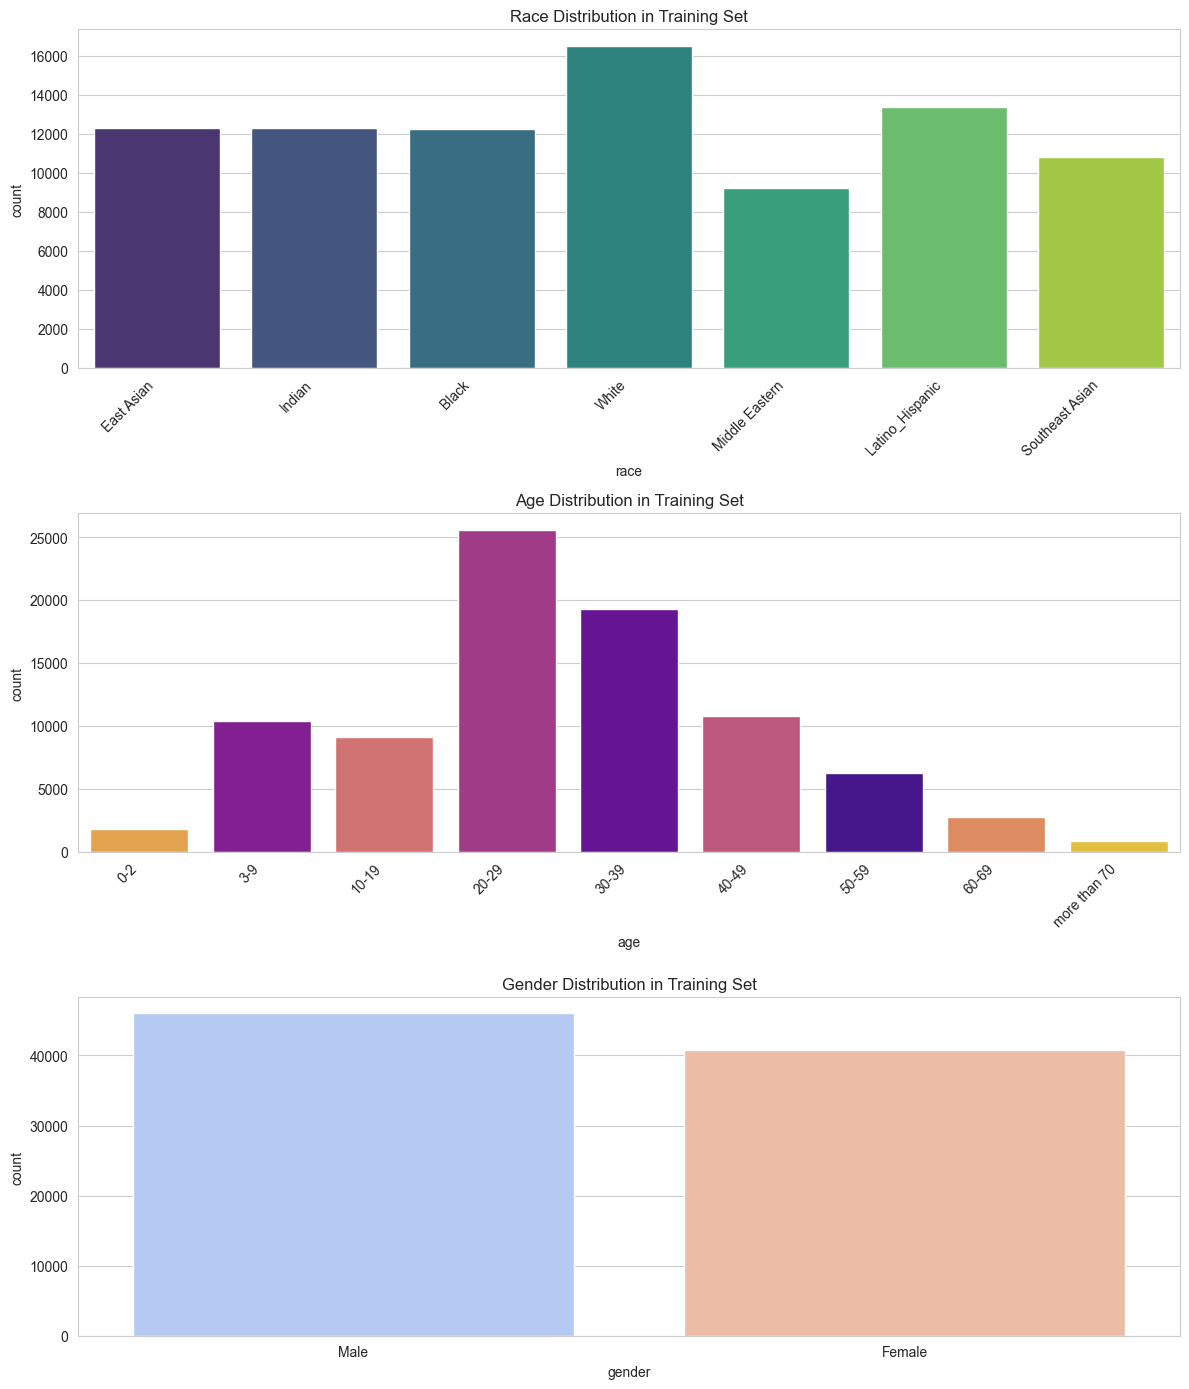

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Age group order
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']

# Create a figure with three subplots (stacked vertically)
plt.figure(figsize=(12, 14))

# Plot 1: Race Distribution
plt.subplot(3, 1, 1)
sns.countplot(data=train_df, x='race', hue='race', palette='viridis', legend=False)
plt.title('Race Distribution in Training Set')
plt.xticks(rotation=45, ha='right')

# Plot 2: Age Distribution
plt.subplot(3, 1, 2)
sns.countplot(data=train_df, x='age', hue='age', order=age_order, palette='plasma', legend=False)
plt.title('Age Distribution in Training Set')
plt.xticks(rotation=45, ha='right')

# Plot 3: Gender Distribution
plt.subplot(3, 1, 3)
sns.countplot(data=train_df, x='gender', hue='gender', palette='coolwarm', legend=False)
plt.title('Gender Distribution in Training Set')

# Final layout
plt.tight_layout()
plt.show()


In [5]:
class FairFaceDataset(Dataset):
    def __init__(self, dataframe, root_dir="data", transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["file"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        age = int(row["age_enc"])
        race = int(row["race_enc"])
        gender = int(row["gender_enc"])

        return image, age, race, gender

# Instantiate Datasets
train_dataset = FairFaceDataset(train_df, root_dir="data", transform=transform_train)
val_dataset = FairFaceDataset(val_df, root_dir="data", transform=transform_val)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print sample size
print(f"Train samples: {len(train_dataset)} — Batches: {len(train_loader)}")
print(f"Val samples: {len(val_dataset)} — Batches: {len(val_loader)}")


Train samples: 86744 — Batches: 1356
Val samples: 10954 — Batches: 172


In [6]:
class FairFaceMultiTask(nn.Module):
    def __init__(self):
        super(FairFaceMultiTask, self).__init__()
        base = models.resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # Remove FC layer
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, 18)  # 7 race + 2 gender + 9 age

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        out = self.fc(x)

        race_logits = out[:, :7]
        gender_logits = out[:, 7:9]
        age_logits = out[:, 9:]

        return race_logits, gender_logits, age_logits

# Instantiate model and move to device
model = FairFaceMultiTask().to(device)

print("Model ready and moved to", device)


C:\Users\Mohammad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mohammad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model ready and moved to cuda


In [16]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

# Loss functions
criterion_race = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.CrossEntropyLoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=30
)

print("Loss functions, optimizer, and scheduler configured")


Loss functions, optimizer, and scheduler configured


In [18]:
from torch.amp import GradScaler, autocast
from tqdm import tqdm

scaler = GradScaler()
best_val_acc = 0.0

for epoch in range(30):
    model.train()
    total_loss = 0
    correct_race = correct_gender = correct_age = total = 0

    print(f"\nEpoch {epoch + 1}/30")
    pbar = tqdm(train_loader, desc="Training", leave=False)

    for images, age_labels, race_labels, gender_labels in pbar:
        images = images.to(device)
        age_labels = age_labels.to(device)
        race_labels = race_labels.to(device)
        gender_labels = gender_labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type="cuda"):
            out_race, out_gender, out_age = model(images)
            loss_race = criterion_race(out_race, race_labels)
            loss_gender = criterion_gender(out_gender, gender_labels)
            loss_age = criterion_age(out_age, age_labels)
            loss = loss_race + loss_gender + loss_age

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        total += images.size(0)
        correct_race += (out_race.argmax(1) == race_labels).sum().item()
        correct_gender += (out_gender.argmax(1) == gender_labels).sum().item()
        correct_age += (out_age.argmax(1) == age_labels).sum().item()

    print(f"Train Loss: {total_loss / len(train_loader):.4f}")
    print(f"Train Accuracy — Race: {100 * correct_race / total:.2f}%, Gender: {100 * correct_gender / total:.2f}%, Age: {100 * correct_age / total:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    val_race = val_gender = val_age = val_total = 0

    with torch.no_grad():
        for images, age_labels, race_labels, gender_labels in tqdm(val_loader, desc="Validating", leave=False):
            images = images.to(device)
            age_labels = age_labels.to(device)
            race_labels = race_labels.to(device)
            gender_labels = gender_labels.to(device)

            out_race, out_gender, out_age = model(images)
            loss_race = criterion_race(out_race, race_labels)
            loss_gender = criterion_gender(out_gender, gender_labels)
            loss_age = criterion_age(out_age, age_labels)
            loss = loss_race + loss_gender + loss_age

            val_loss += loss.item()
            val_total += images.size(0)
            val_race += (out_race.argmax(1) == race_labels).sum().item()
            val_gender += (out_gender.argmax(1) == gender_labels).sum().item()
            val_age += (out_age.argmax(1) == age_labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    acc_race = 100 * val_race / val_total
    acc_gender = 100 * val_gender / val_total
    acc_age = 100 * val_age / val_total
    avg_acc = (acc_race + acc_gender + acc_age) / 3

    print(f"Validation — Loss: {avg_val_loss:.4f}, Race Acc: {acc_race:.2f}%, Gender Acc: {acc_gender:.2f}%, Age Acc: {acc_age:.2f}%")

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        torch.save(model.state_dict(), "best_fairface_model.pth")
        print("### Validation improved. Model saved ###")



Epoch 1/30


Train Loss: 2.8896
Train Accuracy — Race: 52.73%, Gender: 85.42%, Age: 44.95%


Validation — Loss: 2.2247, Race Acc: 63.91%, Gender Acc: 91.13%, Age Acc: 54.15%
### Validation improved. Model saved ###

Epoch 2/30


Train Loss: 2.2374
Train Accuracy — Race: 64.27%, Gender: 91.22%, Age: 53.21%


Validation — Loss: 2.2533, Race Acc: 64.39%, Gender Acc: 92.19%, Age Acc: 51.00%

Epoch 3/30


Train Loss: 2.1434
Train Accuracy — Race: 66.15%, Gender: 91.77%, Age: 54.91%


Validation — Loss: 2.1558, Race Acc: 65.94%, Gender Acc: 91.70%, Age Acc: 54.29%
### Validation improved. Model saved ###

Epoch 4/30


Train Loss: 2.1336
Train Accuracy — Race: 66.24%, Gender: 91.61%, Age: 55.19%


Validation — Loss: 2.2177, Race Acc: 62.66%, Gender Acc: 91.26%, Age Acc: 54.07%

Epoch 5/30


Train Loss: 2.1291
Train Accuracy — Race: 66.45%, Gender: 91.58%, Age: 54.99%


Validation — Loss: 2.2874, Race Acc: 61.53%, Gender Acc: 91.06%, Age Acc: 54.40%

Epoch 6/30


Train Loss: 2.1341
Train Accuracy — Race: 66.22%, Gender: 91.38%, Age: 55.11%


Validation — Loss: 2.3033, Race Acc: 64.37%, Gender Acc: 88.96%, Age Acc: 52.98%

Epoch 7/30


Train Loss: 2.1244
Train Accuracy — Race: 66.45%, Gender: 91.49%, Age: 55.15%


Validation — Loss: 2.2745, Race Acc: 64.64%, Gender Acc: 88.58%, Age Acc: 53.08%

Epoch 8/30


Train Loss: 2.1065
Train Accuracy — Race: 66.75%, Gender: 91.65%, Age: 55.66%


Validation — Loss: 2.2254, Race Acc: 64.35%, Gender Acc: 90.01%, Age Acc: 53.95%

Epoch 9/30


Train Loss: 2.0778
Train Accuracy — Race: 67.14%, Gender: 91.90%, Age: 55.80%


Validation — Loss: 2.2380, Race Acc: 62.39%, Gender Acc: 91.53%, Age Acc: 54.86%

Epoch 10/30


Train Loss: 2.0302
Train Accuracy — Race: 68.13%, Gender: 92.23%, Age: 56.77%


Validation — Loss: 2.1314, Race Acc: 66.61%, Gender Acc: 91.37%, Age Acc: 54.95%
### Validation improved. Model saved ###

Epoch 11/30


Train Loss: 1.9686
Train Accuracy — Race: 69.43%, Gender: 92.83%, Age: 57.59%


Validation — Loss: 2.1475, Race Acc: 65.25%, Gender Acc: 91.49%, Age Acc: 56.63%
### Validation improved. Model saved ###

Epoch 12/30


Train Loss: 1.9146
Train Accuracy — Race: 70.41%, Gender: 93.08%, Age: 58.51%


Validation — Loss: 2.1715, Race Acc: 66.66%, Gender Acc: 90.51%, Age Acc: 54.82%

Epoch 13/30


Train Loss: 1.8499
Train Accuracy — Race: 71.55%, Gender: 93.62%, Age: 59.28%


Validation — Loss: 2.1631, Race Acc: 66.28%, Gender Acc: 91.76%, Age Acc: 55.80%
### Validation improved. Model saved ###

Epoch 14/30


Train Loss: 1.7851
Train Accuracy — Race: 72.87%, Gender: 93.87%, Age: 60.66%


Validation — Loss: 2.1085, Race Acc: 66.84%, Gender Acc: 91.79%, Age Acc: 55.76%
### Validation improved. Model saved ###

Epoch 15/30


Train Loss: 1.7099
Train Accuracy — Race: 74.27%, Gender: 94.41%, Age: 61.54%


Validation — Loss: 2.1136, Race Acc: 67.62%, Gender Acc: 91.98%, Age Acc: 55.89%
### Validation improved. Model saved ###

Epoch 16/30


Train Loss: 1.6239
Train Accuracy — Race: 75.94%, Gender: 95.06%, Age: 63.11%


Validation — Loss: 2.1375, Race Acc: 67.47%, Gender Acc: 91.42%, Age Acc: 56.20%

Epoch 17/30


Train Loss: 1.5277
Train Accuracy — Race: 77.87%, Gender: 95.63%, Age: 64.86%


Validation — Loss: 2.1614, Race Acc: 66.49%, Gender Acc: 92.37%, Age Acc: 55.85%

Epoch 18/30


Train Loss: 1.4103
Train Accuracy — Race: 80.09%, Gender: 96.13%, Age: 67.14%


Validation — Loss: 2.2359, Race Acc: 66.99%, Gender Acc: 92.37%, Age Acc: 55.14%

Epoch 19/30


Train Loss: 1.2896
Train Accuracy — Race: 82.36%, Gender: 96.61%, Age: 69.32%


Validation — Loss: 2.3191, Race Acc: 66.83%, Gender Acc: 91.92%, Age Acc: 55.35%

Epoch 20/30


Train Loss: 1.1418
Train Accuracy — Race: 84.95%, Gender: 97.19%, Age: 72.65%


Validation — Loss: 2.4391, Race Acc: 66.84%, Gender Acc: 92.29%, Age Acc: 55.18%

Epoch 21/30


Train Loss: 0.9851
Train Accuracy — Race: 87.77%, Gender: 97.84%, Age: 76.07%


Validation — Loss: 2.6142, Race Acc: 66.56%, Gender Acc: 92.23%, Age Acc: 55.52%

Epoch 22/30


Train Loss: 0.8253
Train Accuracy — Race: 90.50%, Gender: 98.21%, Age: 79.72%


Validation — Loss: 2.8042, Race Acc: 66.85%, Gender Acc: 92.47%, Age Acc: 55.19%

Epoch 23/30


Train Loss: 0.6647
Train Accuracy — Race: 92.80%, Gender: 98.68%, Age: 83.88%


Validation — Loss: 3.0386, Race Acc: 66.47%, Gender Acc: 92.56%, Age Acc: 55.21%

Epoch 24/30


Train Loss: 0.5061
Train Accuracy — Race: 94.97%, Gender: 99.18%, Age: 87.72%


Validation — Loss: 3.3872, Race Acc: 66.67%, Gender Acc: 92.32%, Age Acc: 54.97%

Epoch 25/30


Train Loss: 0.3759
Train Accuracy — Race: 96.61%, Gender: 99.41%, Age: 91.18%


Validation — Loss: 3.6493, Race Acc: 66.79%, Gender Acc: 92.46%, Age Acc: 55.31%

Epoch 26/30


Train Loss: 0.2746
Train Accuracy — Race: 97.61%, Gender: 99.56%, Age: 93.91%


Validation — Loss: 3.8246, Race Acc: 66.62%, Gender Acc: 92.56%, Age Acc: 55.20%

Epoch 27/30


Train Loss: 0.1932
Train Accuracy — Race: 98.60%, Gender: 99.73%, Age: 96.05%


Validation — Loss: 4.0669, Race Acc: 66.67%, Gender Acc: 92.43%, Age Acc: 55.16%

Epoch 28/30


Train Loss: 0.1400
Train Accuracy — Race: 99.07%, Gender: 99.81%, Age: 97.49%


Validation — Loss: 4.1987, Race Acc: 66.55%, Gender Acc: 92.55%, Age Acc: 55.33%

Epoch 29/30


Train Loss: 0.1132
Train Accuracy — Race: 99.32%, Gender: 99.85%, Age: 98.10%


Validation — Loss: 4.2524, Race Acc: 66.61%, Gender Acc: 92.52%, Age Acc: 55.11%

Epoch 30/30


Train Loss: 0.0995
Train Accuracy — Race: 99.44%, Gender: 99.88%, Age: 98.43%


Validation — Loss: 4.2521, Race Acc: 66.40%, Gender Acc: 92.47%, Age Acc: 55.40%


C:\Users\Mohammad\AppData\Local\Temp\ipykernel_28348\10583051.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_fairface_model.pth"

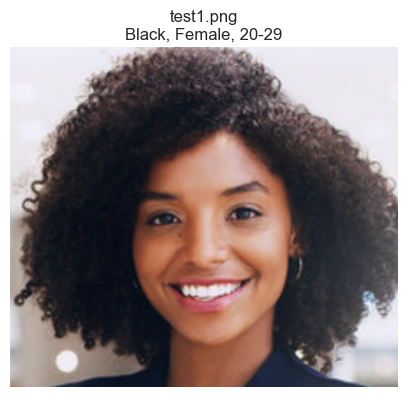

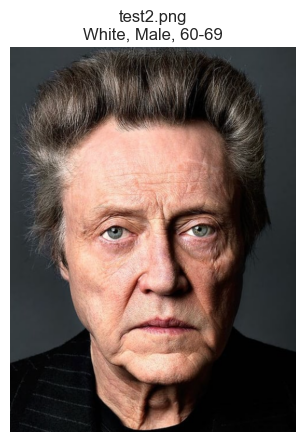

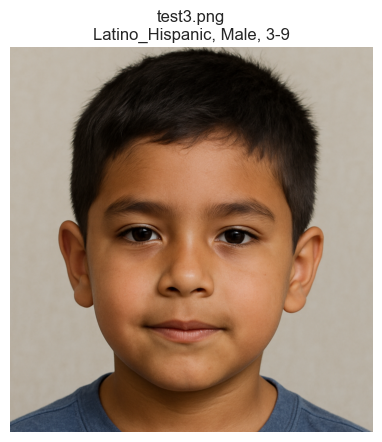

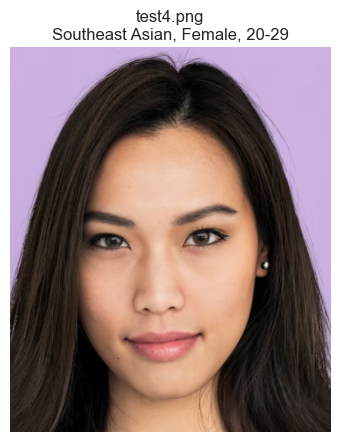

In [16]:
import os
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Label mappings
age_classes = ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
race_classes = ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
gender_classes = ['Female', 'Male']

# Transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load model
model = FairFaceMultiTask().to(device)
model.load_state_dict(torch.load("best_fairface_model.pth"))
model.eval()

# Directory with images
image_dir = "test"

# Get list of image files
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

# Loop through and predict
for filename in image_files:
    img_path = os.path.join(image_dir, filename)
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out_race, out_gender, out_age = model(input_tensor)
        pred_race = race_classes[out_race.argmax(1).item()]
        pred_gender = gender_classes[out_gender.argmax(1).item()]
        pred_age = age_classes[out_age.argmax(1).item()]

    # Show image + prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{filename}\n{pred_race}, {pred_gender}, {pred_age}")
    plt.show()


Using cache found in C:\Users\Mohammad/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Mohammad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_28348\908825920.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions tha

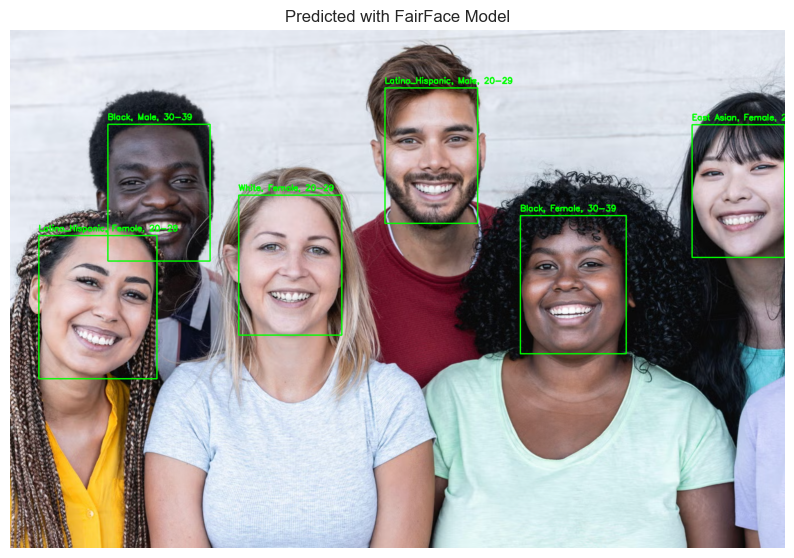

In [17]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.amp import autocast
import matplotlib.pyplot as plt

# --- Labels ---
race_labels = ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
gender_labels = ['Female', 'Male']
age_labels = ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Load Model ---
class FairFaceMultiTask(nn.Module):
    def __init__(self):
        super(FairFaceMultiTask, self).__init__()
        base = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, 18)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        out = self.fc(x)
        return out[:, :7], out[:, 7:9], out[:, 9:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FairFaceMultiTask().to(device)
model.load_state_dict(torch.load("best_fairface_model.pth", map_location=device))
model.eval()

# --- Load DNN Face Detector ---
face_net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt.txt", 
    "res10_300x300_ssd_iter_140000.caffemodel"
)

def detect_faces_dnn(image, conf_thresh=0.95):
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], False, False)
    face_net.setInput(blob)
    detections = face_net.forward()
    boxes = []
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if conf > conf_thresh:
            box = detections[0, 0, i, 3:7] * [w, h, w, h]
            x1, y1, x2, y2 = box.astype(int)
            boxes.append((x1, y1, x2 - x1, y2 - y1))
    return boxes

# --- Load & Predict on Image ---
image_path = "m.png"
image = cv2.imread(image_path)
orig = image.copy()

faces = detect_faces_dnn(image)

for (x, y, w, h) in faces:
    face = image[y:y+h, x:x+w]
    if face.size == 0:
        continue
    face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    face_tensor = transform(face_pil).unsqueeze(0).to(device)

    with torch.no_grad(), autocast(device_type='cuda'):
        out_race, out_gender, out_age = model(face_tensor)
        race = out_race.softmax(1).cpu().squeeze()
        gender = out_gender.softmax(1).cpu().squeeze()
        age = out_age.softmax(1).cpu().squeeze()

    race_label = race_labels[race.argmax().item()]
    gender_label = gender_labels[gender.argmax().item()]
    age_label = age_labels[age.argmax().item()]
    label = f"{race_label}, {gender_label}, {age_label}"

    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, label, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# --- Show Output in Notebook ---
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Predicted with FairFace Model")
plt.show()
